# **Preprocessing**

Preprocessing is a crucial phase in the training of machine learning models that involves the application of various techniques to the input data (images) to improve their quality, reduce noise and dimensionality, select relevant features, among other objectives, in order to improve the accuracy and performance of the model. In general, images require preprocessing because they have different sizes and noise, which can affect image quality and analysis accuracy.

To improve image quality, highlight important features, and reduce noise, various techniques are used. Noise in an image refers to any unwanted distortion or interference that may have been introduced into the image during capture, transmission, processing, or storage. For example, hand or tripod movement when imaging can cause noise in the form of blurred images, lack of brightness, viewing angles (which can cause distortion), and image compression (which can reduce quality) when uploading images to the Internet, among others.

Preprocessing must be tailored to the data set and model in question, as the techniques used may vary according to the model requirements. There are certain differences in data processing between DL and ML. Although both give importance to quality improvement and use common techniques such as normalization. Preprocessing in machine learning of images also focuses on segmentation of important areas while preprocessing in DL focuses on providing the model with good image processing and data augmentation.

In image processing, the most common techniques in ML include illumination normalization, contrast enhancement, and denoising to improve quality and feature detection. These techniques are implemented using different methods, such as histogram equalization, Gaussian filtering, among others.

**In this notebook, we will focus on the specific preprocessing steps required for traditional machine learning models. A separate Jupyter notebook will cover preprocessing tailored for deep learning models.**

Process:

       -*Image resizing* to homogenize the size, facilitate comparison and speed up the training process. An optimal size of 224 * 224 pixels is set for all retinal images.

       -*Grayscale conversion* technique is applied to reduce the complexity in the images. This technique is essential to be able to extract features using GLCM after completing all the preprocessing.

       -*Histogram equalization* is implemented to improve the contrast and visual quality of the fundus images. This technique is especially useful for enhancing areas with uneven illumination, with reflections in the image.

       -*Gaussian filter* is used to reduce noise and improve the visual quality of the image.

       -*Segmentation / Thresholding technique* is used to segment the image and separate the objects or regions of interest according to the level of intensity or color. In our case, we use this binarization technique to separate regions containing fundus irregularities, such as microaneurysms and exudates, hemorrhages, blood vessels, among others that are indicative of the presence and severity of diabetic retinopathy. Once the image is segmented, the lesions are highlighted on the image and can be identified and measured to assess the presence of DR. Once the image is segmented, the lesions are highlighted on the image and can be identified and measured to assess the presence of DR.

Here, each preprocessing method applied is explained in more detail.

* **Image resizing** is used to reduce the amount of data in a high-resolution image, speed up its processing and homogenize the size of the data. The new image size is achieved by modifying the pixel resolution (number of pixels in the image width and height).
* **Grayscale conversion**: This conversion consists of transforming a color image into an image containing only shades of gray, namely 256 gray levels. The grayscale representation of an image is necessary for feature extraction with GLCM subsequently implemented in ML models. By converting a color image to grayscale, the complexity of the image information is reduced, since only intensity information is considered. In addition, the variability of the color images is reduced simplifying the comparison and improving the consistency of the images.
* **Histogram equalization** is an image processing technique used to enhance the contrast and visual quality of an image. By redistributing pixel values it achieves an image with an even distribution of intensity levels, especially useful in unevenly lit images with dark and light areas. With this technique, dark areas of the input image will have their pixel values reallocated to increase their visibility, and bright areas that are too bright will be reduced to achieve more uniform illumination in the output image. Images that are too bright or too dark will have a narrow histogram as pixel values are grouped into a range of intensity levels.
* **Gaussian filter**, since images often contain noise, there are several techniques to reduce it, among them the Gaussian filter. This filter is based on the Gaussian function describing a bell curve and is used to weight neighboring pixel values and smooth out abrupt intensity changes in the image. This filter improves the visual quality of the image by reducing abrupt transitions between different regions of the image.
* **Segmentation**, to separate the objects or regions of interest according to the level of intensity or color, there is the thresholding technique. This method converts the original image into a black and white image where pixels above a certain threshold become white and pixels below a certain threshold become black. The threshold is defined by an automatic algorithm based on the intensity distribution of the image. One of the most commonly used thresholding techniques is Otsu's, which calculates an optimal threshold value that separates the foreground (bright regions) from the background (dark regions).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from PIL import Image
from skimage import data, io, color
import sys
import cv2
from cv2 import cvtColor
from skimage.feature import greycomatrix, greycoprops

In [ ]:
train_csv = '/content/drive/MyDrive/train.csv'
train_images= '/content/drive/MyDrive/train_images.zip'

In [ ]:
with ZipFile('/content/drive/MyDrive/train_images.zip', 'r') as zip_ref:
    # Loop through all files in the zip file
    for filename in zip_ref.namelist():
        # Check if the file is an image (you may want to adjust this based on your image file types)
        if filename.endswith('.png'):
            # Extract the image file to a temporary location if the directory 'DR' doesn't already exist
            if not os.path.exists('DR'):
                os.makedirs('DR')
                zip_ref.extract(filename, path='DR')
            else:
                if not os.path.exists(f'DR/{filename}'):
                    zip_ref.extract(filename, path='DR')

In [ ]:
train = pd.read_csv(train_csv, delimiter=',')
#Creating column
train['labels']= np.where(train['diagnosis'] == 0, 'No', 'Si')
train.dataframeName = 'train.csv'
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')
#len(df.columns)
train.head()

There are 3662 rows and 3 columns in the training set


,id_code,diagnosis,labels
0,000c1434d8d7,2.0,Si
1,001639a390f0,4.0,Si
2,0024cdab0c1e,1.0,Si
3,002c21358ce6,0.0,No
4,005b95c28852,0.0,No


In [ ]:
train['id_length'] = train['id_code'].str.len()
print(train['id_length'].unique())
train = train[train['id_length'] != 1]
train

[12  1]


,id_code,diagnosis,labels,id_length
0,000c1434d8d7,2.0,Si,12
1,001639a390f0,4.0,Si,12
2,0024cdab0c1e,1.0,Si,12
3,002c21358ce6,0.0,No,12
4,005b95c28852,0.0,No,12
...,...,...,...,...
3657,ffa47f6a7bf4,2.0,Si,12
3658,ffc04fed30e6,0.0,No,12
3659,ffcf7b45f213,2.0,Si,12
3660,ffd97f8cd5aa,0.0,No,12


# Visualization of preprocess method

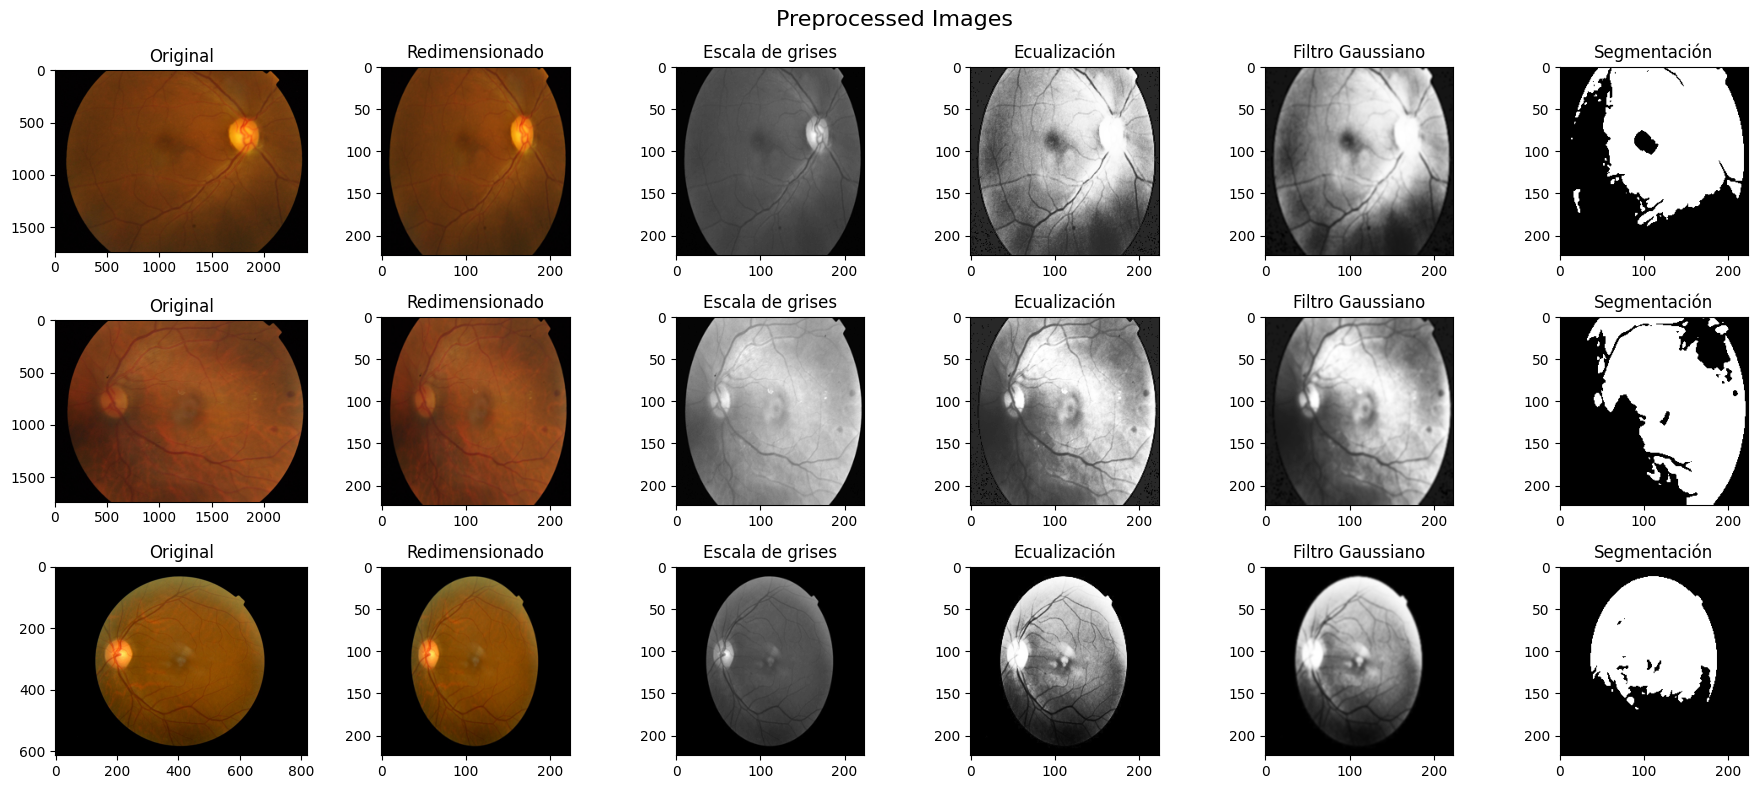

In [ ]:
import os
import matplotlib.pyplot as plt

directory = 'DR'

# Select the first three images in the directory
image_files = os.listdir(directory)[:3]

# Create a subplot with 6 columns (for each preprocess method) and 3 rows (for each image)
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(18, 8))

for i, filename in enumerate(image_files):
    filepath = os.path.join(directory, filename)
    with Image.open(filepath) as img:

        # Display the original image in the first column
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original')

        # Resize the image and display it in the second column
        output_size = (224, 224)  # optimal input size
        #resized_img = cv2.resize(img, output_size)
        resized_img = img.copy().resize(output_size)
        axs[i, 1].imshow(resized_img)
        axs[i, 1].set_title('Redimensionado')

        # Convert the image to grayscale and display it in the third column
        gray_img = cv2.cvtColor(np.array(resized_img), cv2.COLOR_BGR2GRAY)
        axs[i, 2].imshow(gray_img, cmap='gray')
        axs[i, 2].set_title('Escala de grises')

        # Apply histogram equalization and display it in the fourth column
        equalized_img = cv2.equalizeHist(gray_img)
        axs[i, 3].imshow(equalized_img, cmap='gray')
        axs[i, 3].set_title('Ecualización')

        # Apply Gaussian blur and display it in the fifth column
        blur = cv2.GaussianBlur(equalized_img, (5,5), 0)
        axs[i, 4].imshow(blur, cmap='gray')
        axs[i, 4].set_title('Filtro Gaussiano')

        # Apply thresholding and display it in the sixth column
        #thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        #thresh = cv2.threshold(blur, 240, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        axs[i, 5].imshow(thresh, cmap='gray')
        axs[i, 5].set_title('Segmentación')


# Set the title of the subplot
fig.suptitle('Preprocessed Images', fontsize=16)

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the subplot
plt.show()

From left to right:

* Original Image

* Resized Image

* Grayscale Conversion

* Histogram Equalization

* Gaussian Filtering

* Segmentation
